In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Задача

Найти точку минимума функции

$$
f(x_1, x_2) = e^{\frac{7}{2}}e^{\frac{x_1}{2}}(x_1 + x_{2}^2 - 8x_2 + 23)
$$

из начальной точки $[x_1 = 8, \ x2 = -7]$ методом Ньютона-Рафсона. Для одномерной минимизации использовать метод равномерного поиска. Для поиска интервала унимодальности использовать алгоритм Свенна. В окрестности точки минимума построить линии уровня и траекторию поиска.

# Теоретическая часть

Коротко говоря, в методе Ньютона-Рафсона мы приближаем в заданной точке исследуемую функцию квадратичной (обрубаем все слагаемые в ряде Тейлора после вторых степеней) и ищем точку минимума как будто наша функция - квадратичная.

Для квадратичной функции мы можем аналитически определить направление поска следующей точки:

$$
x^{k+1} = x^{k} - [\nabla^{2}f(x^k)]^{-1}\nabla f(x^k)
$$

где $\nabla^{2}$ - гессиан. Это просто метод Ньютона. Метод Ньютона-Рафсона же отличается лишь наличием выбора "шага" $\alpha_k$:

$$
x^{k+1} = x^{k} - \alpha_k[\nabla^{2}f(x^k)]^{-1}\nabla f(x^k)
$$

Шаг мы определяем из задачи минимизации

$$
f(x^k - \alpha_k[\nabla^{2}f(x^k)]^{-1}\nabla f(x^k)) \rightarrow \min \\
\alpha_k > 0
$$

Эту задачу минимизации мы решаем при помощи алгоритма Свенна для поиска интервала унимодальности (интервала где гарантированно есть минимум), на котором мы ищем минимум при помощи равномерного поиска.

# Практическая часть

Мы реализовали класс NeutonRafson, объекты которого умеют делать метод compute:
$$
void compute(std::function<float(VectorXd&)>& f,
            std::vector<std::function<float(VectorXd&)>>& nabla,
            std::vector<std::vector<std::function<float(VectorXd&)>>>& gesse,
            VectorXd& p_init,
            float eps=0.0001,
            float learning_rate=0.1)
$$

Поясним его сигнатуру. Прежде всего отметим, что мы пользуемся библиотекой Eigen для матричных вычислений (умножения на вектора, взятие обратной матрицы...). Функция compute принимает на вход

1) $f$ - исследуемая функция. Не обязательно функция двух переменных, может быть сколько угодно.

2) $std::vector<std::function<float(VectorXd&)>>& nabla$ - градиент, как вектор фукнций, задается пользователем.

3) $std::vector<std::vector<std::function<float(VectorXd&)>>>& gesse$ - матрица фукнций, гессиан.

4) $VectorXd& p_init$ - точка из которой мы начинаем поиск минимума

5) float eps=0.0001 - точность, критерий остановки: если норма градиента меньше эпсилон, то считаем что нашли экстремум.

6) float learning_rate=0.1 - дополнительный множитель на шаг градиентного спуска, позволяющий регулировать скорость сходимости (порой бывает полезен для того чтоб добится сходимости метода).


### private методы

Метод

$$
static float _get_step(
            std::function<float(VectorXd&)>& f,
            VectorXd& p,
            VectorXd& direction,
            float learning_rate)
$$

ищет коэффициент $\alpha_k$ на основе метода Свенна, реализованного в 

$$
static std::pair<float, float> _get_unimodal_interval(
            std::function<float(float)>& f,
            float lrate,
            float thr = 100)
$$

и равномерного поиска:

$$
static float _get_min_uniform(
            std::function<float(float)>& f,
            std::pair<float, float>& interval,
            float lrate)
$$


Так же есть вспомогательные функции static VectorXd _materialize_vector, static MatrixXd _materialize_matrix 

для вычисления градиента и Гессиана в точке.


На выходе программа пишет последовательность шагов (тьюплы (x, y, f(x,y))) в файл "neuton_rafson.csv".

# Результат

In [14]:
data_bad = pd.read_csv('cmake-build-debug/neuton_rafson_inf.csv', header=None)
data = pd.read_csv('cmake-build-debug/neuton_rafson.csv', header=None)

Из точки $[x_1 = 8, \ x2 = -7]$ не удалось добится сходимости метода. Градиентный спуск "улетает на бесконечность". Из-за отрицательной экспоненнты, при больших отрицательных значениях $x_1$ наша функция почти константа, поэтому попадая в эту область, градиентный спуск не может из нее выйти:

In [15]:
data_bad

,0,1,2
0,8.00000,-7.00000,245894.000000
1,7.79812,-7.02135,222723.000000
2,7.59626,-7.04261,201736.000000
3,7.39443,-7.06376,182726.000000
4,7.19262,-7.08483,165508.000000
...,...,...,...
185,-29.11080,-9.98725,0.002742
186,-29.31070,-10.00020,0.002484
187,-29.51050,-10.01310,0.002250
188,-29.71040,-10.02610,0.002038


Однако, если взять другую начальную точку, например (8, 8), метод сходится к точке минимума, легко определяемой аналитически: (-9, 4). Хотя сходится тоже не всегда, сходимость зависит от параметра learning_rate. В случае данных приведенных ниже, learning_rate = 0.01

In [19]:
data

,0,1,2
0,8.000000,8.00000,56049.300000
1,7.333330,5.33333,20872.200000
2,5.574940,5.17226,7501.730000
3,3.838090,5.01802,2679.630000
4,2.127910,4.87050,948.651000
5,0.451267,4.72976,331.309000
6,-1.182390,4.59609,113.180000
7,-2.759660,4.47010,37.174300
8,-4.260870,4.35286,11.264600
9,-5.656150,4.24617,2.749930


А вот график линий уровня и траектории поиска

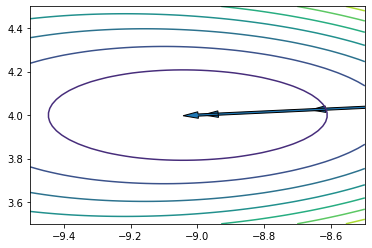

In [18]:
x, y = np.mgrid[-9.5:-8.5:50j,
                3.5:4.5:50j]

z = np.exp(3.5)*np.exp(x/2)*(x + y**2 - 8*y + 23)

fig, ax = plt.subplots()

ax.contour(x, y, z)
for i in range(data.shape[0]-1):
    plt.arrow(data[0][i], data[1][i], data[0][i+1] - data[0][i], data[1][i+1] - data[1][i], width=0.01)

plt.show()